In [32]:
import os
import torch
import clip
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

# === CONFIG ===
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model_name = "ViT-B/32"
embedding_dir = os.path.join("Output", "vectorized_output_MEN")
csv_path = "filtered_data_MEN_ONLY.csv"

# === LOAD MODEL AND DATA ===
model, preprocess = clip.load(clip_model_name, device=device)

metadata = pd.read_csv(csv_path)
vectors = np.load(os.path.join(embedding_dir, "vectors_men.npy"))

with open(os.path.join(embedding_dir, "filenames_men.pkl"), "rb") as f:
    filenames = pickle.load(f)

# === INDEX METADATA BY IMAGE ID ===
metadata_dict = {str(row['id']): row for _, row in metadata.iterrows()}

recommend_map = {
    "Shoes": ["Topwear", "Bottomwear"],
    "Bottomwear": ["Topwear", "Shoes"],
    "Topwear": ["Bottomwear", "Shoes"]
}

#print(f"[✔] Loaded {len(vectors)} vectors and {len(filenames)} filenames")
#Things used from CSV file
#subCategory 
#usage
#articleType
#season

In [46]:
def metadata_compatibility(input_row, candidate_row):
    score = 0.0

    def safe_lower(val):
        return str(val).strip().lower() if pd.notna(val) else ""

    input_color = safe_lower(input_row.get('baseColour'))
    candidate_color = safe_lower(candidate_row.get('baseColour'))
    input_usage = safe_lower(input_row.get('usage'))
    candidate_usage = safe_lower(candidate_row.get('usage'))
    input_season = safe_lower(input_row.get('season'))
    candidate_season = safe_lower(candidate_row.get('season'))

    # === 1. COLOR HARMONY (0.4) ===
    color_match = {
        'black': ['white', 'red', 'beige', 'pink', 'blue', 'green', 'yellow'],
        'white': ['black', 'blue', 'red', 'pink', 'grey', 'beige', 'green', 'brown'],
        'grey': ['black', 'white', 'pink', 'blue', 'red', 'yellow', 'green'],
        'blue': ['white', 'grey', 'beige', 'yellow', 'pink', 'brown'],
        'red': ['white', 'black', 'grey', 'beige', 'pink', 'brown'],
        'beige': ['white', 'black', 'blue', 'brown', 'green', 'pink'],
        'pink': ['white', 'grey', 'beige', 'blue', 'red'],
        'green': ['white', 'black', 'brown', 'beige', 'yellow', 'grey'],
        'brown': ['beige', 'white', 'green', 'blue', 'pink'],
        'yellow': ['blue', 'white', 'grey', 'green', 'brown']
    }

    if candidate_color in color_match.get(input_color, []):
        score += 0.4
    else:
        score += 0.2  # weak match

    # === 2. USAGE MATCH (0.3) ===
    if input_usage == candidate_usage:
        score += 0.3

    # === 3. SEASON MATCH (0.3) ===
    if (
        input_season == candidate_season or
        input_season == "all season" or
        candidate_season == "all season"
    ):
        score += 0.3

    return score


def recommend_outfit_real(input_img_path, alpha=0.7, beta=0.3):
    input_img = preprocess(Image.open(input_img_path).convert("RGB")).unsqueeze(0).to(device)
    with torch.no_grad():
        input_vec = model.encode_image(input_img).cpu().numpy()

    input_id = os.path.splitext(os.path.basename(input_img_path))[0]
    input_row = metadata_dict.get(input_id)
    if input_row is None:
        raise ValueError(f"Image ID {input_id} not found in metadata.")

    input_cat = input_row['subCategory']
    input_type = str(input_row.get("articleType", "")).strip().lower()
    input_usage = input_row['usage']
    input_season = input_row['season'].strip().lower()

    output_items = {}

    # === Input Jacket Case ===
    if input_type == 'jackets':
        target_categories = ['Topwear', 'Bottomwear', 'Shoes']

        for target_cat in target_categories:
            indices = [
                i for i, fname in enumerate(filenames)
                if (
                    (item_id := os.path.splitext(os.path.basename(fname))[0]) in metadata_dict and
                    metadata_dict[item_id]['subCategory'] == target_cat and
                    str(metadata_dict[item_id].get("articleType", "")).strip().lower() != 'jackets' and
                    (
                        input_season != 'winter' or
                        metadata_dict[item_id]['season'].strip().lower() in ['winter', 'all season']
                    )
                )
            ]

            best_score = -1
            best_path = None

            for idx in indices:
                candidate_id = os.path.splitext(os.path.basename(filenames[idx]))[0]
                candidate_row = metadata_dict[candidate_id]

                visual_sim = cosine_similarity(input_vec, vectors[idx].reshape(1, -1))[0][0]
                meta_score = metadata_compatibility(input_row, candidate_row)

                final_score = alpha * visual_sim + beta * meta_score
                if final_score > best_score:
                    best_score = final_score
                    best_path = filenames[idx]

            if best_path:
                output_items[target_cat] = {
                    "path": best_path,
                    "score": float(best_score)
                }

        return {
            "input_id": input_id,
            "input_category": input_cat,
            "input_usage": input_usage,
            "input_season": input_season,
            "input_articleType": input_type,
            "recommendations": output_items
        }

    # === Recommend a Jacket if Input is Winter Item ===
    if input_season == "winter" and input_type != "jackets":
        jacket_indices = [
            i for i, fname in enumerate(filenames)
            if (
                (item_id := os.path.splitext(os.path.basename(fname))[0]) in metadata_dict and
                str(metadata_dict[item_id].get("articleType", "")).strip().lower() == 'jackets' and
                metadata_dict[item_id]['season'].strip().lower() in ['winter', 'all season']
            )
        ]

        best_jacket_score = -1
        best_jacket_path = None

        for idx in jacket_indices:
            candidate_id = os.path.splitext(os.path.basename(filenames[idx]))[0]
            candidate_row = metadata_dict[candidate_id]

            visual_sim = cosine_similarity(input_vec, vectors[idx].reshape(1, -1))[0][0]
            meta_score = metadata_compatibility(input_row, candidate_row)

            final_score = alpha * visual_sim + beta * meta_score
            if final_score > best_jacket_score:
                best_jacket_score = final_score
                best_jacket_path = filenames[idx]

        if best_jacket_path:
            output_items['Jacket'] = {
                "path": best_jacket_path,
                "score": float(best_jacket_score)
            }

    # === Normal Recommendation ===
    if input_cat not in recommend_map:
        raise ValueError(f"Unsupported category: {input_cat}")

    target_categories = recommend_map[input_cat]

    for target_cat in target_categories:
        indices = [
            i for i, fname in enumerate(filenames)
            if (
                (item_id := os.path.splitext(os.path.basename(fname))[0]) in metadata_dict and
                metadata_dict[item_id]['subCategory'] == target_cat and
                str(metadata_dict[item_id].get("articleType", "")).strip().lower() != 'jackets' and
                (
                    input_season != 'winter' or
                    metadata_dict[item_id]['season'].strip().lower() in ['winter', 'all season', "summer"]
                )
            )
        ]

        best_score = -1
        best_path = None

        for idx in indices:
            candidate_id = os.path.splitext(os.path.basename(filenames[idx]))[0]
            candidate_row = metadata_dict[candidate_id]

            visual_sim = cosine_similarity(input_vec, vectors[idx].reshape(1, -1))[0][0]
            meta_score = metadata_compatibility(input_row, candidate_row)

            final_score = alpha * visual_sim + beta * meta_score
            if final_score > best_score:
                best_score = final_score
                best_path = filenames[idx]

        if best_path:
            output_items[target_cat] = {
                "path": best_path,
                "score": float(best_score)
            }

    return {
        "input_id": input_id,
        "input_category": input_cat,
        "input_usage": input_usage,
        "input_season": input_season,
        "input_articleType": input_type,
        "recommendations": output_items
    }


In [47]:
import matplotlib.pyplot as plt
from PIL import Image
# no need to put in the  Backend
def show_outfit(input_img_path, outfit_result):
    input_img = Image.open(input_img_path).convert("RGB")
    
    recs = outfit_result["recommendations"]
    n_items = 1 + len(recs)  # 1 for input + recommended items

    fig, axs = plt.subplots(1, n_items, figsize=(4 * n_items, 5))
    if n_items == 1:
        axs = [axs]  # Ensure axs is iterable

    # Show input image
    axs[0].imshow(input_img)
    axs[0].set_title(f"Input\n({outfit_result['input_category']})", fontsize=12)
    axs[0].axis("off")

    # Show recommended items
    for i, (cat, rec) in enumerate(recs.items(), start=1):
        try:
            rec_img = Image.open(rec["path"]).convert("RGB")
            axs[i].imshow(rec_img)
            axs[i].set_title(f"{cat}\nScore: {rec['score']:.2f}", fontsize=12)
            axs[i].axis("off")
        except Exception as e:
            axs[i].text(0.5, 0.5, f"Error loading image\n{e}", ha='center', va='center')
            axs[i].axis("off")

    plt.tight_layout()
    plt.show()


how the output is 

In [48]:
recommend_outfit_real("9176.jpg")

{'input_id': '9176',
 'input_category': 'Bottomwear',
 'input_usage': 'Casual',
 'input_season': 'all season',
 'input_articleType': 'jeans',
 'recommendations': {'Topwear': {'path': 'subCategory_MEN\\Topwear\\2102.jpg',
   'score': 0.9055420662799343},
  'Shoes': {'path': 'subCategory_MEN\\Shoes\\4733.jpg',
   'score': 0.8502730696340879}}}

In [49]:
recommend_outfit_real("1530.jpg")

{'input_id': '1530',
 'input_category': 'Topwear',
 'input_usage': 'Sports',
 'input_season': 'winter',
 'input_articleType': 'jackets',
 'recommendations': {'Topwear': {'path': 'subCategory_MEN\\Topwear\\9976.jpg',
   'score': 0.8606837840630139},
  'Bottomwear': {'path': 'subCategory_MEN\\Bottomwear\\9078.jpg',
   'score': 0.8343394875344747},
  'Shoes': {'path': 'subCategory_MEN\\Shoes\\3251.jpg',
   'score': 0.7914528391111264}}}

# Only Examples

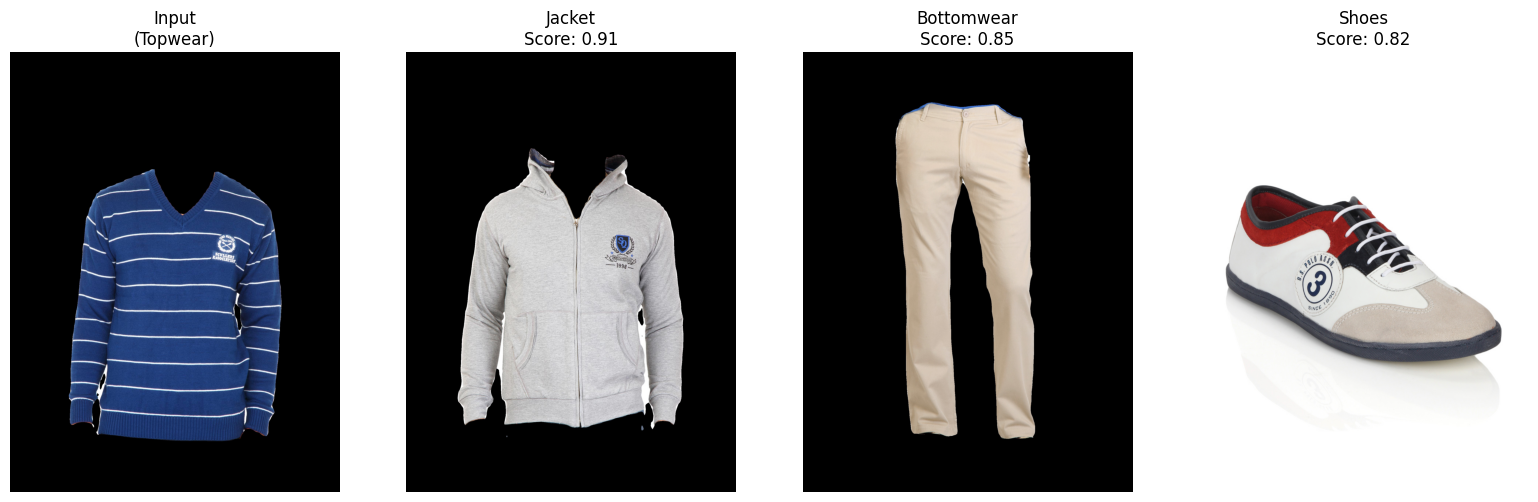

In [50]:
result = recommend_outfit_real("11075.jpg")
show_outfit("11075.jpg", result)


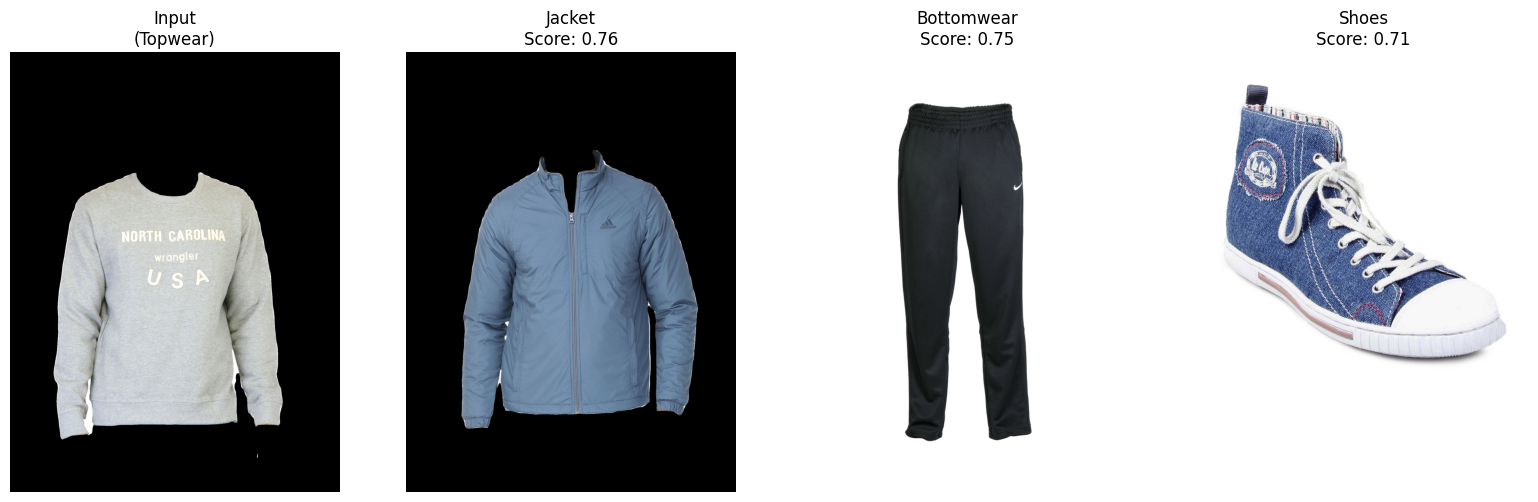

In [51]:
result = recommend_outfit_real("20197.jpg")
show_outfit("20197.jpg", result)


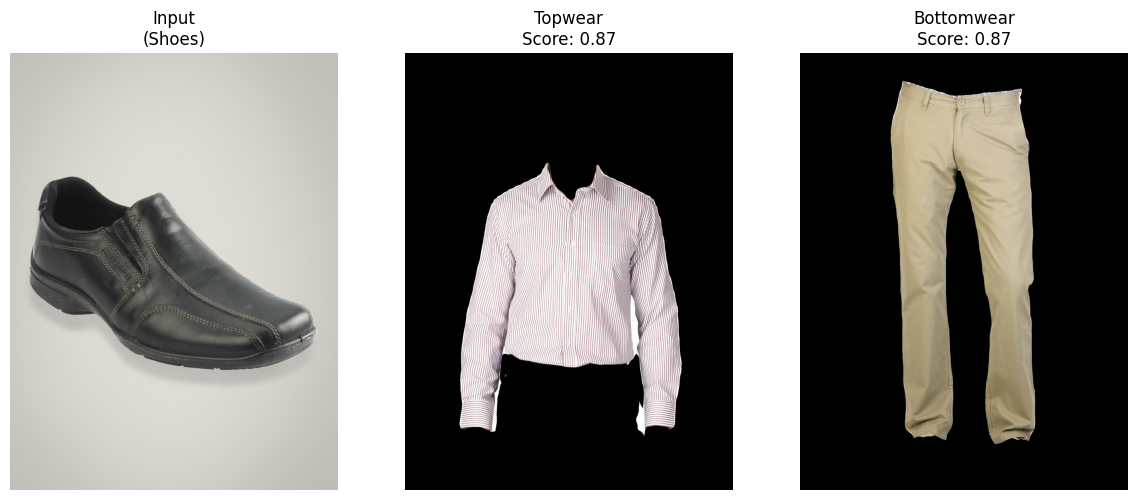

In [52]:
img="2390.jpg"
result = recommend_outfit_real(img)
show_outfit(img, result)


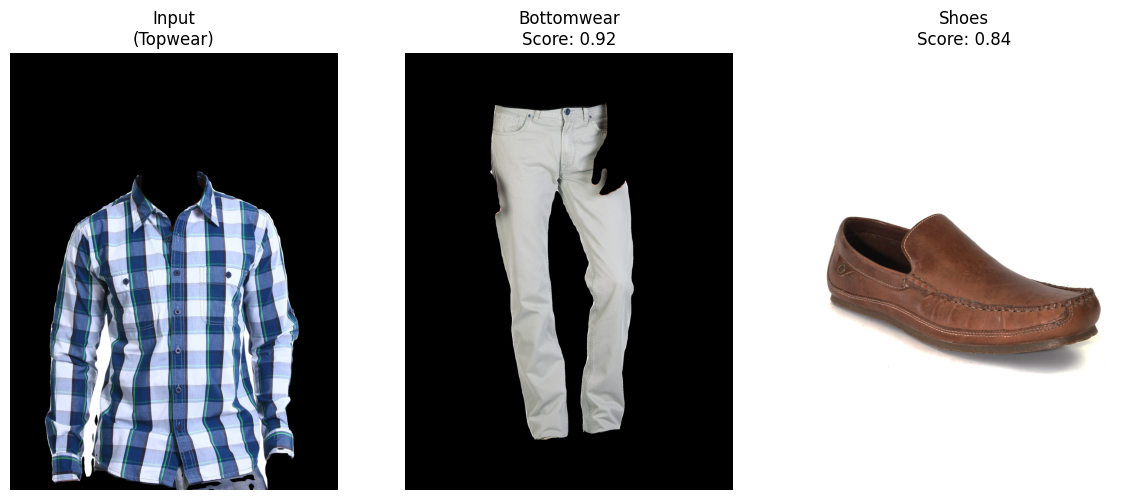

In [53]:
img="2165.jpg"
result = recommend_outfit_real(img)
show_outfit(img, result)


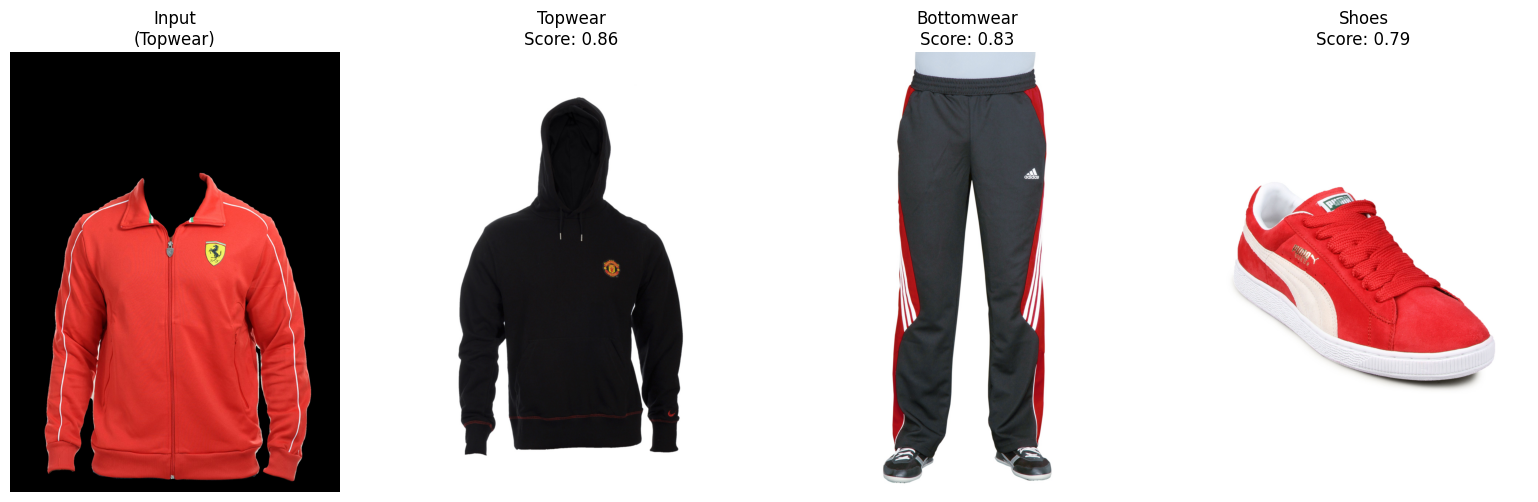

In [54]:
result = recommend_outfit_real("1530.jpg")
show_outfit("1530.jpg", result)


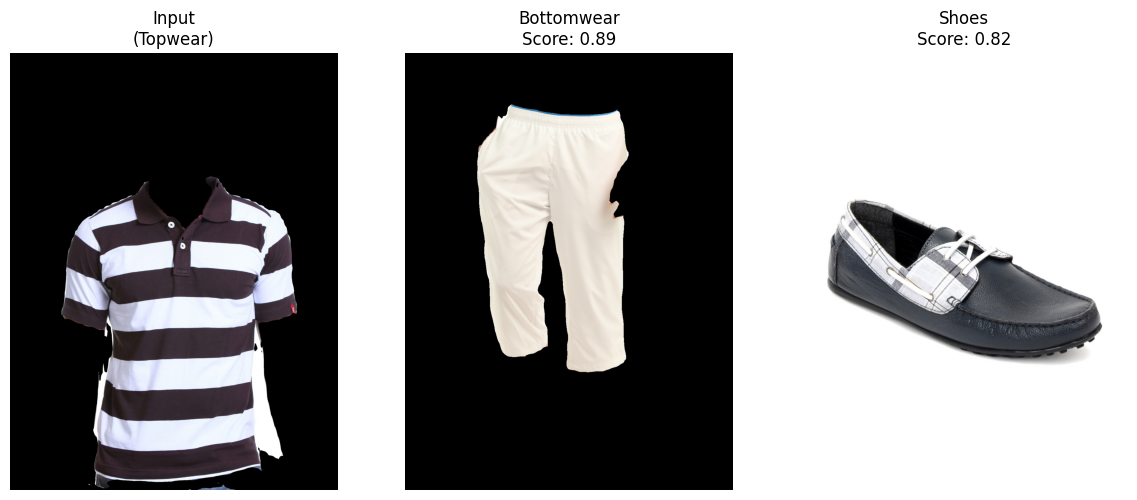

In [55]:
result = recommend_outfit_real("2171.jpg")
show_outfit("2171.jpg", result)

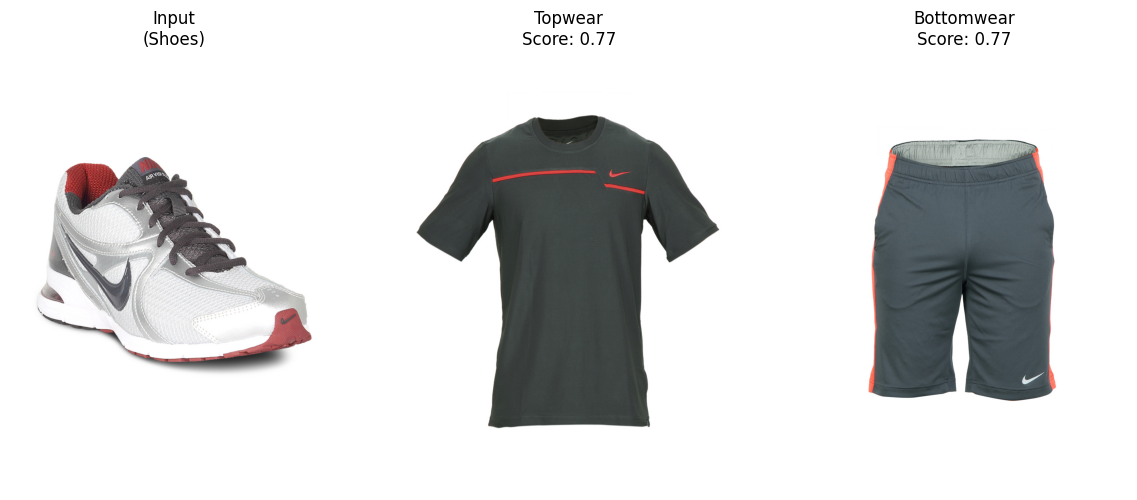

In [56]:
result = recommend_outfit_real("1836.jpg")
show_outfit("1836.jpg", result)

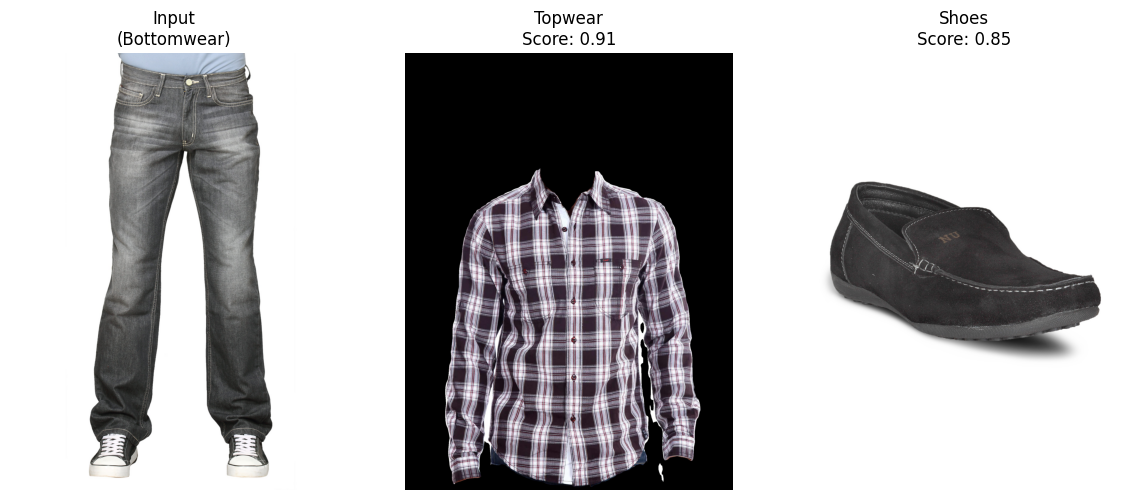

In [57]:
result = recommend_outfit_real("9176.jpg")
show_outfit("9176.jpg", result)

In [58]:
recommend_outfit_real("9176.jpg")

{'input_id': '9176',
 'input_category': 'Bottomwear',
 'input_usage': 'Casual',
 'input_season': 'all season',
 'input_articleType': 'jeans',
 'recommendations': {'Topwear': {'path': 'subCategory_MEN\\Topwear\\2102.jpg',
   'score': 0.9055420662799343},
  'Shoes': {'path': 'subCategory_MEN\\Shoes\\4733.jpg',
   'score': 0.8502730696340879}}}